In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import pickle
import tqdm
import ultralytics

In [7]:
CLASS_NAMES = ['aeroplane' ,'bicycle' ,'bird' ,'boat' ,'bottle' ,
               'bus' ,'car' ,'cat' ,'chair' ,'cow' ,'diningtable' ,
               'dog' ,'horse' ,'motorbike' ,'person' ,'pottedplant' ,
               'sheep' ,'sofa' ,'train' ,'tvmonitor']

COLORS = [
    [255, 0, 0],        # Красный
    [0, 255, 0],        # Зеленый
    [0, 0, 255],        # Синий
    [255, 255, 0],      # Желтый
    [255, 0, 255],      # Фиолетовый
    [0, 255, 255],      # Бирюзовый
    [128, 0, 0],        # Темно-красный
    [0, 128, 0],        # Темно-зеленый
    [0, 0, 128],        # Темно-синий
    [128, 128, 0],      # Темно-желтый
    [128, 0, 128],      # Темно-фиолетовый
    [0, 128, 128],      # Темно-бирюзовый
    [67, 67, 67],    # Серый
    [255, 165, 0],      # Оранжевый
    [67, 0, 130],    # Розовый
    [139, 69, 19],      # Коричневый
    [169, 169, 169],    # Темно-серый
    [12, 138, 14],    # Светло-зеленый
    [255, 20, 147],     # Гелиотроп
    [255, 99, 71]       # Темно-красный
] #, dtype=np.uint8


In [7]:
!ls ../runs/all_models/orig/nano

test  train


In [2]:
experiments = ['all_models_Vehicle']
training_data = ['GD_train','GD_train_val','orig']
models = ['nano', 'small', 'medium', 'large', 'extra_large']
data_split = ['train', 'test']
metrics = ['epoch', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2']

experiments_settings = [experiments, training_data, models, data_split]

query = (
    (['all_models'], 0), 
    (['orig'], 0),
    (['small', 'nano'], 1),
    (['train', 'test'], 0)
)

def get_plot_data(experiments_settings, query):
    """
    experiments_settings (tuple) - все комбинации экспериментов в правильном порядке
    query - запрос в формате tuple; 
        первое значение (array) - список комбинаций экспериментов
        второе значение (bool) - нужно выводить на одном графике или на разных
    """
    # result = []
    main_path = '../runs'
    all_paths = get_all_paths([([(main_path, '')], '')], query)
    all_paths = fill_endings(all_paths)
    data = get_data(all_paths)
    return all_paths, data

    

def get_all_paths(paths, query):
    new_paths = []
    current_split = query[0]
    query = query[1:] if len(query) > 1 else None

    if current_split[1] == 0:
        for split_dir in current_split[0]:
            for plot_data_path in paths:
                new_paths.append(([(f'{x[0]}/{split_dir}', f'{x[1]}') for x in plot_data_path[0]], 
                                  f'{plot_data_path[1]} {split_dir}'))

    elif current_split[1] == 1:
        for plot_data_path in paths:
            extended_plot_data = []
            for split_dir in current_split[0]:
                extended_plot_data.extend([(f'{x[0]}/{split_dir}', f'{x[1]} {split_dir}') for x in plot_data_path[0]])
            new_paths.append((extended_plot_data, plot_data_path[1]))

    if query is None:
        return new_paths
    else:
        return get_all_paths(new_paths, query)


def fill_endings(paths):
    new_paths = []
    for plot_data_path in (paths):
        new_paths.append(([], plot_data_path[1]))
        for data_path in plot_data_path[0]:
            if data_path[0].endswith('train'):
                new_data_path = f'{data_path[0]}/results.csv'
            else:
                new_data_path = f'{data_path[0]}/results.pickle'
            new_paths[-1][0].append((new_data_path, data_path[1]))
    return new_paths


def get_data(paths):
    all_data = []
    for plot_data_path in (paths):
        all_data.append(([], plot_data_path[1]))
        for data_path in plot_data_path[0]:
            if data_path[0].endswith('.csv'):
                data = prepare_df(data_path[0])
            else:
                data = pickle.load(open(data_path[0], "rb"))
            all_data[-1][0].append((data, data_path[1]))
    return all_data
            

def prepare_df(path):
    df = pd.read_csv(path)
    df.columns = [x.split(' ')[-1] for x in df.columns]
    return df          


In [3]:
### PLOTS

def get_metric_df(dataframe, metric_name):
    metric = dataframe[metric_name]
    metric = metric.astype('float64')
    epoch = dataframe['epoch']
    epoch = epoch.astype('int64')
    return (epoch, metric), ('epoch', metric_name)

def get_pickle(pickle_data, metric_name, index):
    metric = getattr(pickle_data, metric_name)
    return ([index], [metric]), ('index', metric_name)


def plot_results_metrics(results, metric_config, dim = (8,5)):
    n_rows = len(results)
    
    fig, axis = plt.subplots(nrows = n_rows, ncols = 1, figsize = (dim[0], dim[1] * n_rows))
    plt.subplots_adjust(wspace= 0.4, hspace=0.4)

    if isinstance(axis, np.ndarray) is False:
        axis = np.array([axis])

    for ax, plot_res in zip(axis, results):
        title = plot_res[1]
        
        for index_res, res in enumerate(plot_res[0]):

            for index_metric, config in enumerate(metric_config):
                metric_func, metric_name, plot_type = config
                if isinstance(res[0], ultralytics.utils.metrics.Metric):
                    plot_data = metric_func(res[0], metric_name, index_res)
                else:
                    plot_data = metric_func(res[0], metric_name)

                lenestyles= ['-', '--', '-.', ':']
                label = f'{res[1]} {metric_name}'
            
                if plot_type == 'plot':
                    ax.plot(*plot_data[0], label = label, linestyle=lenestyles[index_metric])
                elif plot_type == 'scatter':
                    ax.scatter(*plot_data[0], label = label)


                ax.set_xlabel(plot_data[1][0], fontsize = 24,)
                
        ax.legend(fontsize = 18, loc='right', borderaxespad=-17) 
        ax.grid(which = "major", linewidth = 1)
        ax.xaxis.set_tick_params(labelsize=18)
        ax.yaxis.set_tick_params(labelsize=18)
        ax.set_ylabel('Metrics', fontsize = 24)
        ax.set_title(title, fontsize = 30)

    plt.show()


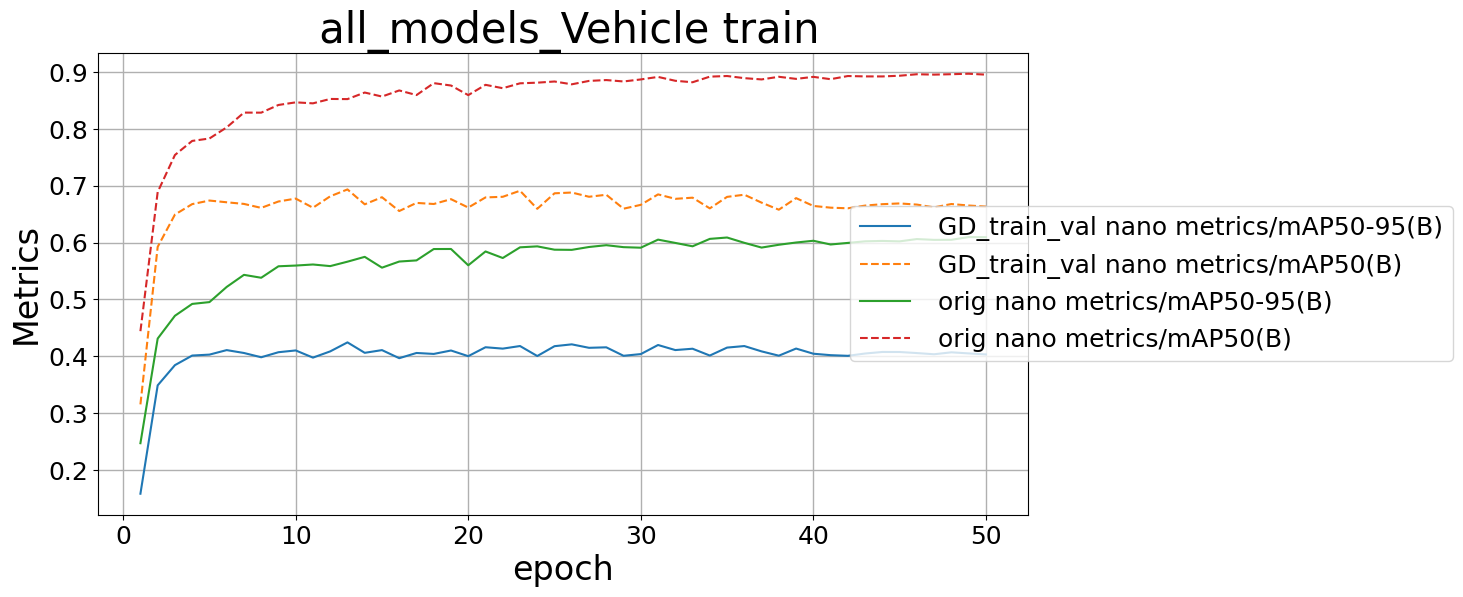

In [12]:
experiments = ['all_models_Vehicle']
training_data = ['GD_train','GD_train_val','orig']
models = ['nano', 'small', 'medium', 'large', 'extra_large']
data_split = ['train', 'test']
metrics = ['epoch', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2']

query = (
    (['all_models_Vehicle'], 0), 
    (['GD_train_val', 'orig'], 1),
    (['nano'], 1),
    (['train'], 0)
)

res = get_plot_data(experiments_settings, query)
res[0]

m_config = [
    (get_metric_df, 'metrics/mAP50-95(B)','plot'),
    (get_metric_df, 'metrics/mAP50(B)','plot'),
    ]

plot_results_metrics(res[1], m_config, dim = (12,6))



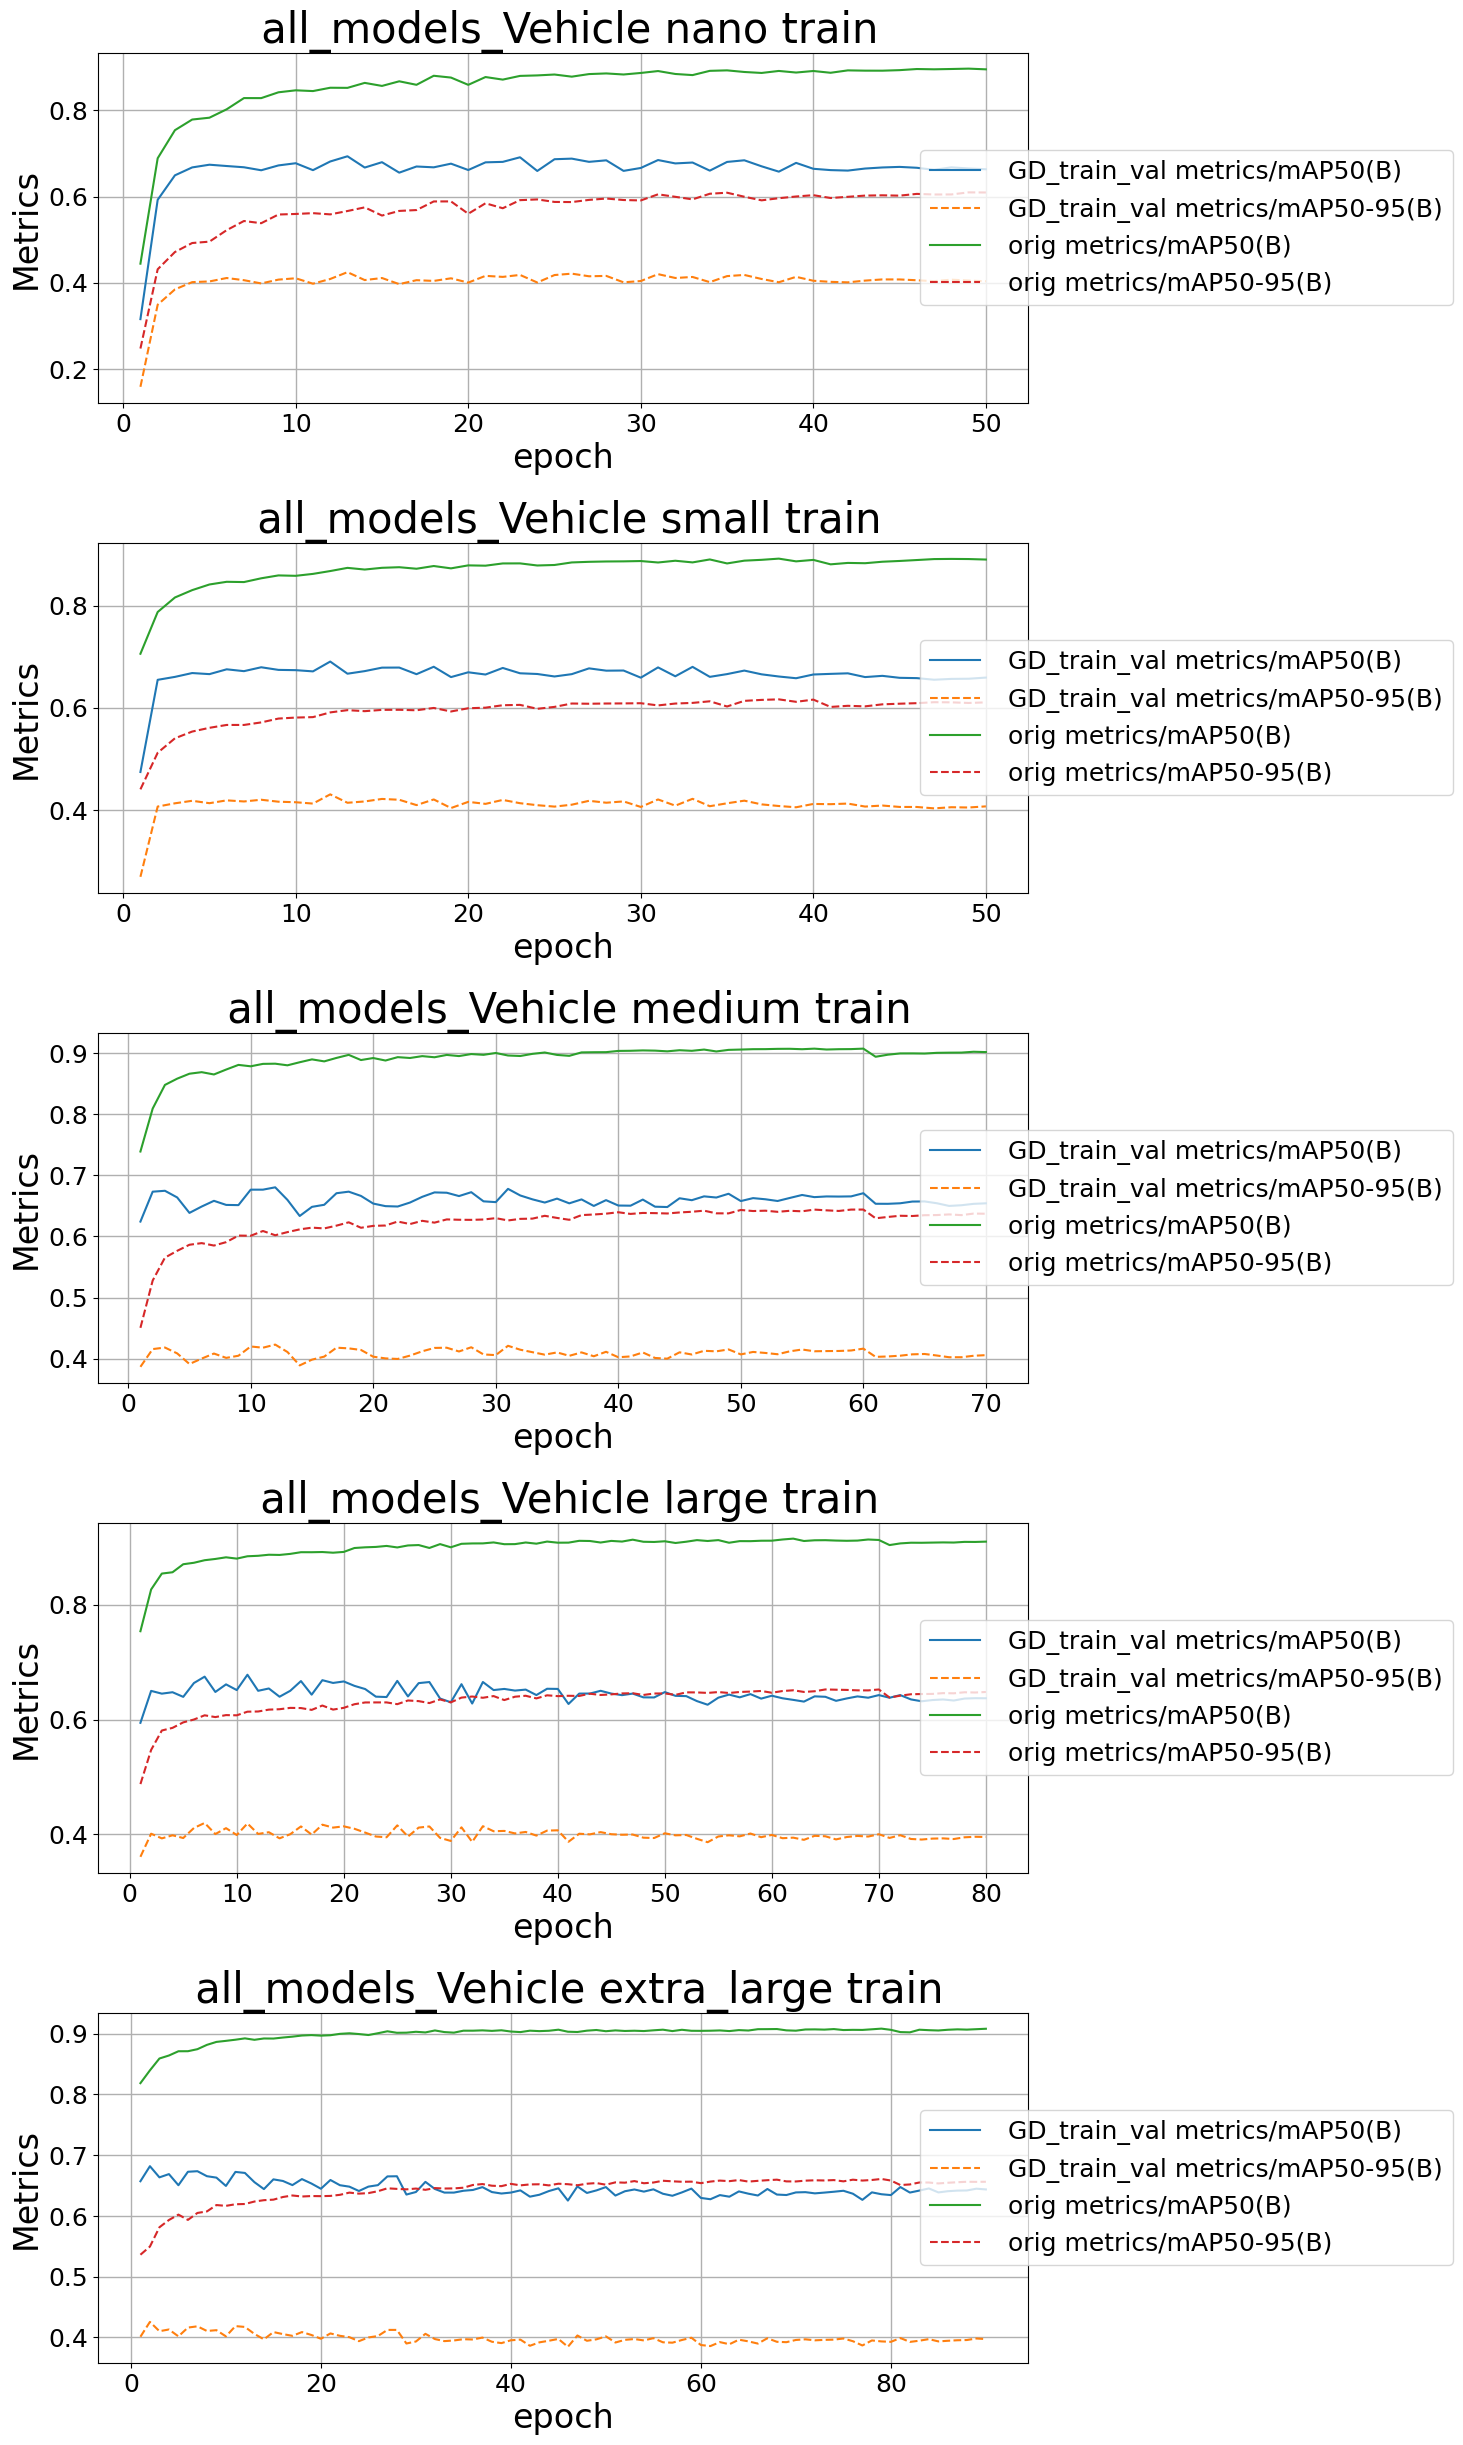

In [10]:
query = (
    (['all_models_Vehicle'], 0), 
    (['GD_train_val', 'orig'], 1),
    (['nano', 'small', 'medium', 'large', 'extra_large'], 0),
    (['train'], 0)
)

res = get_plot_data(experiments_settings, query)
res[0]

m_config = [
    (get_metric_df, 'metrics/mAP50(B)','plot'),
    (get_metric_df, 'metrics/mAP50-95(B)','plot'),
    ]

plot_results_metrics(res[1], m_config, dim = (12,6))

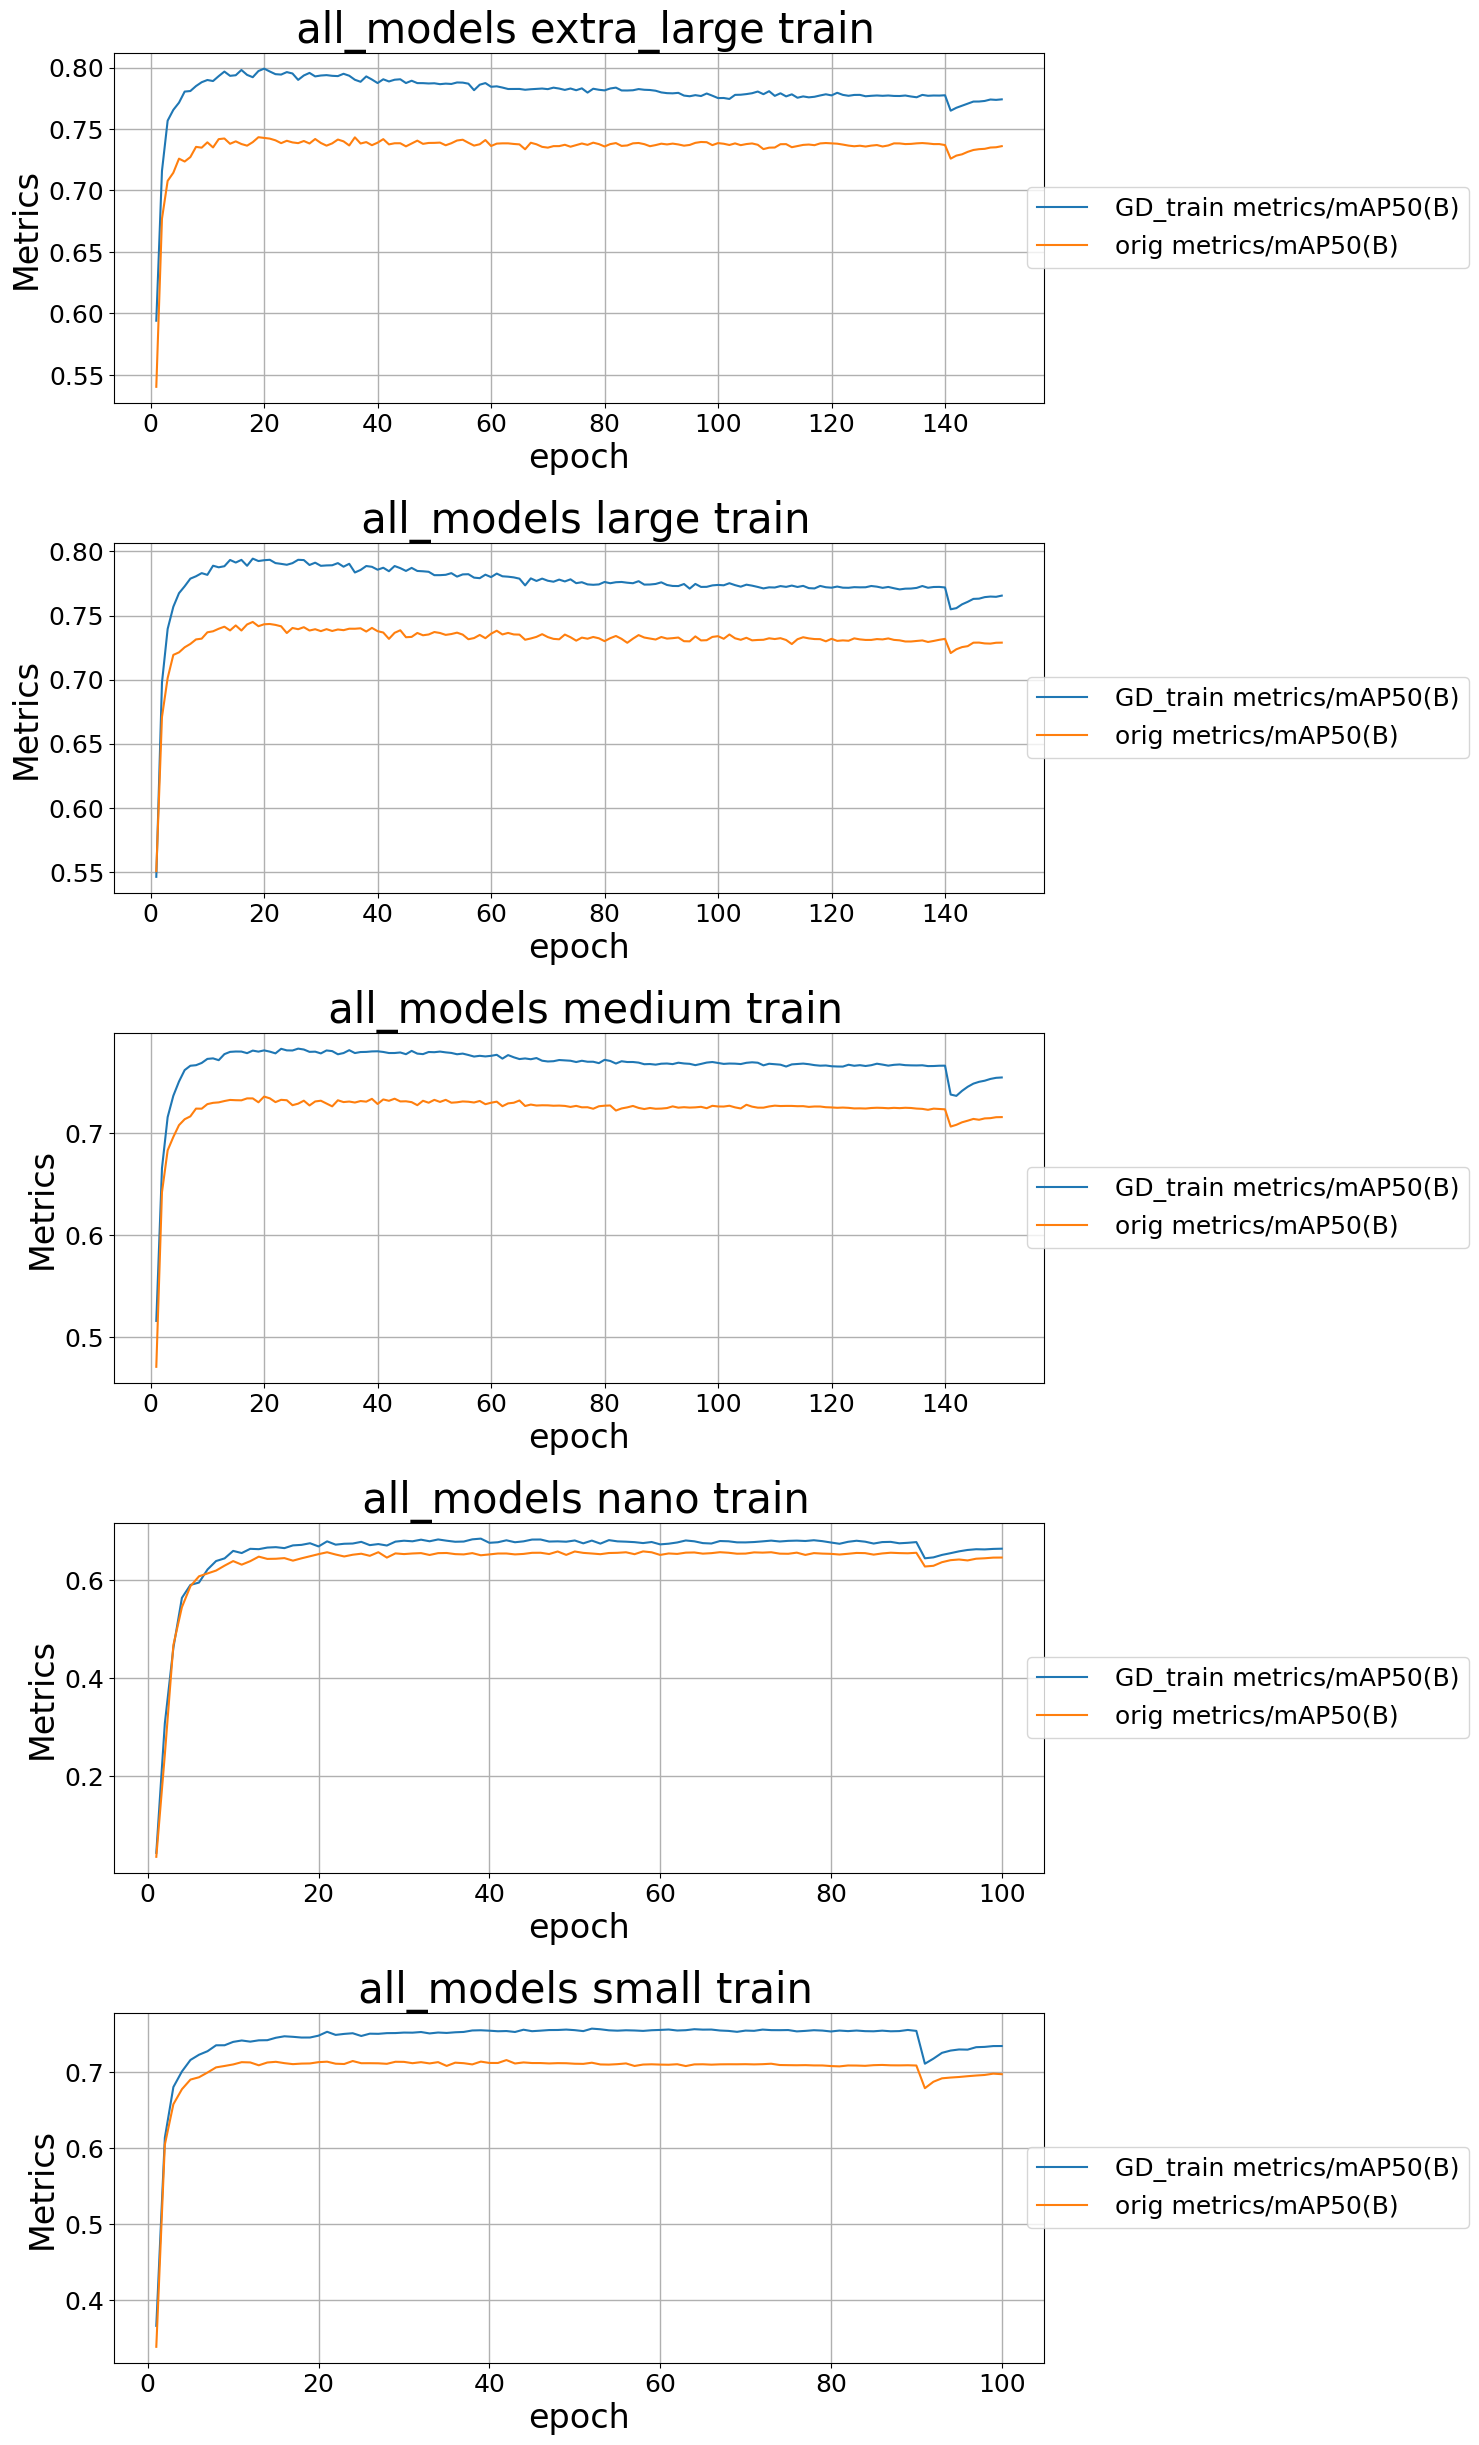

In [125]:
query = (
    (['all_models'], 0), 
    (['GD_train', 'orig'], 1),
    (['nano', 'small', 'medium', 'large', 'extra_large'], 0),
    (['train'], 0)
)

res = get_plot_data(experiments_settings, query)
res[0]


m_config = [
    (get_metric_df, 'metrics/mAP50(B)','plot'),
    ]

plot_results_metrics(res[1], m_config, dim = (12,6))

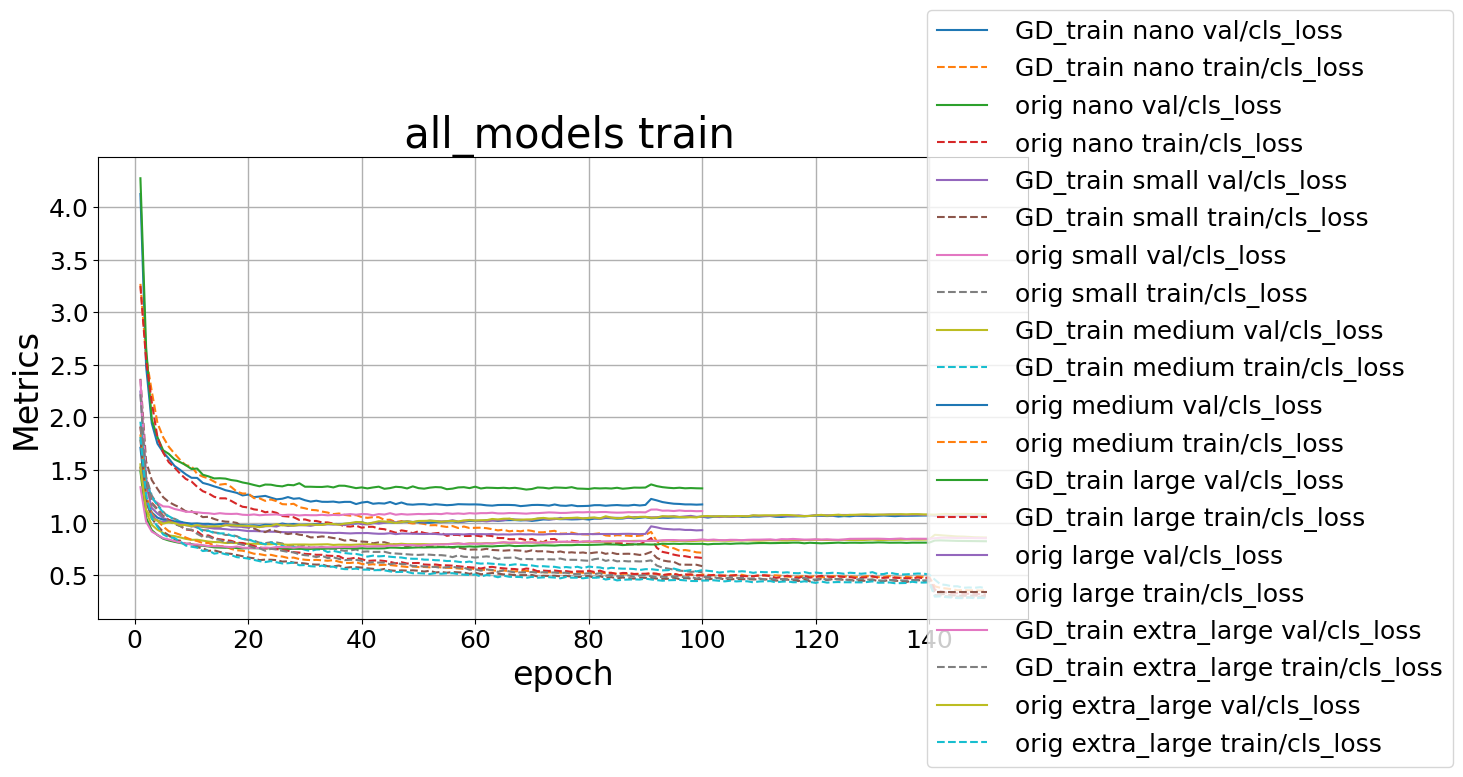

In [66]:
query = (
    (['all_models'], 0), 
    (['GD_train', 'orig'], 1),
    (['nano', 'small', 'medium', 'large', 'extra_large'], 1),
    (['train'], 0)
)

res = get_plot_data(experiments_settings, query)
res[0]

m_config = [
    (get_metric_df, 'val/cls_loss','plot'),
    (get_metric_df, 'train/cls_loss','plot'),
    # (get_metric_df, 'train/dfl_loss','plot'),
    # (get_metric_df, 'val/box_loss','plot'),
    # (get_metric_df, 'val/cls_loss','plot')
    ]

plot_results_metrics(res[1], m_config, dim = (12,6))

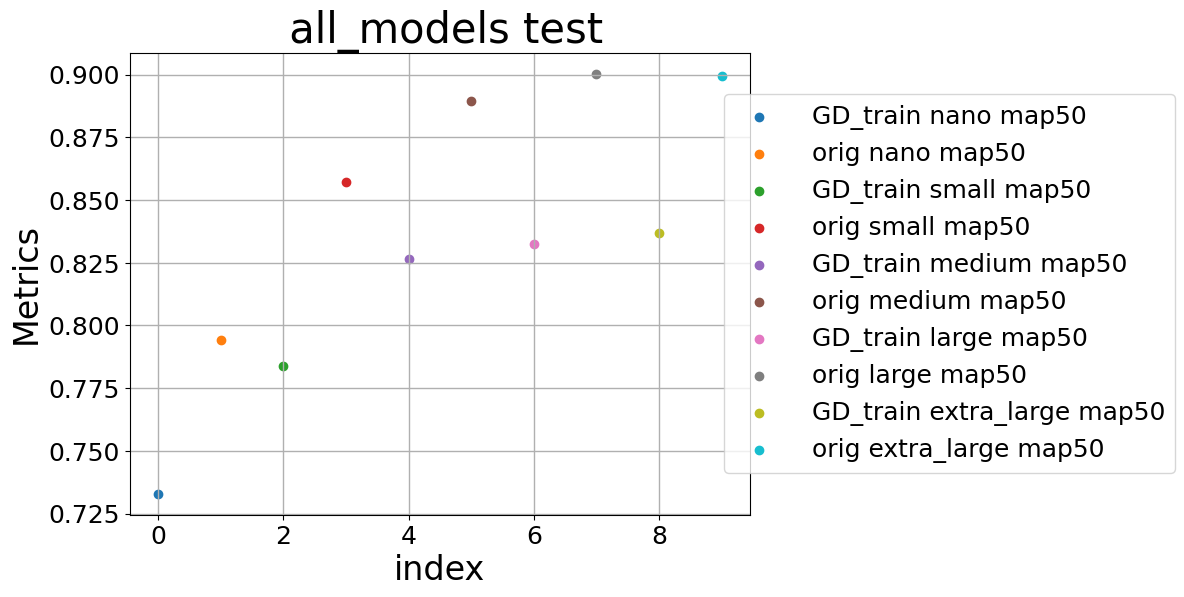

In [20]:
query = (
    (['all_models'], 0), 
    (['GD_train', 'orig'], 1),
    (['nano', 'small', 'medium', 'large', 'extra_large'], 1),
    (['test'], 0)
)

res = get_plot_data(experiments_settings, query)
res[0]

m_config = [
    (get_pickle, 'map50','scatter'),
    ]

plot_results_metrics(res[1], m_config, dim = (8,6))

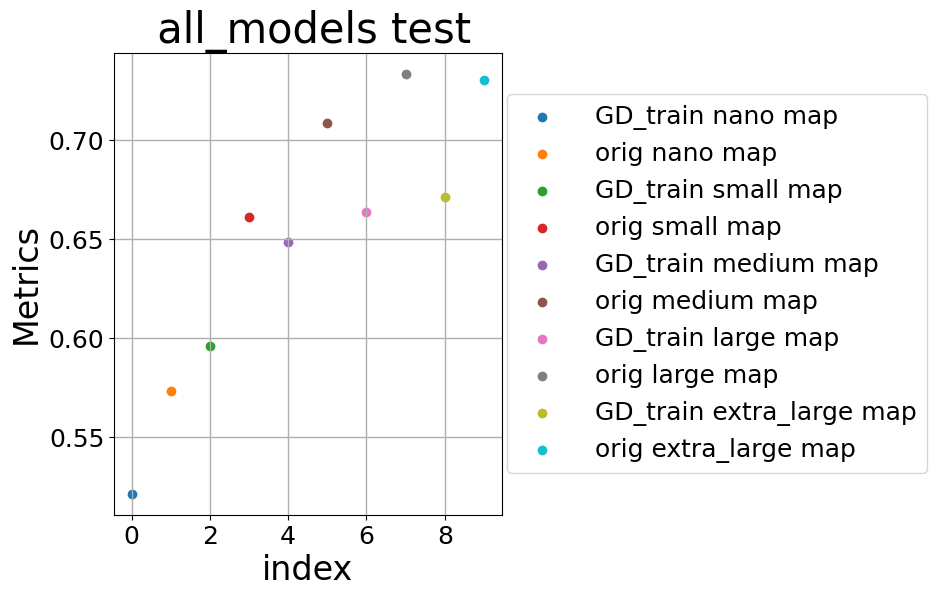

In [31]:
query = (
    (['all_models'], 0), 
    (['GD_train', 'orig'], 1),
    (['nano', 'small', 'medium', 'large', 'extra_large'], 1),
    (['test'], 0)
)

res = get_plot_data(experiments_settings, query)
res[0]

m_config = [
    # (get_pickle, 'map50','scatter'),
    (get_pickle, 'map','scatter'),
    # (get_metric_df, 'val/cls_loss','plot')
    ]

plot_results_metrics(res[1], m_config, dim = (5,6))

## PASCAL VOC

In [11]:
test_path = [
    '../runs/all_models/orig/nano/test/results.pickle',
    '../runs/all_models/orig/small/test/results.pickle',
    '../runs/all_models/orig/medium/test/results.pickle',
    '../runs/all_models/orig/large/test/results.pickle',
    '../runs/all_models/orig/extra_large/test/results.pickle',
    ]


test_path_GD = [
    '../runs/all_models/GD_train_val/nano/test/results.pickle',
    '../runs/all_models/GD_train_val/small/test/results.pickle',
    '../runs/all_models/GD_train_val/medium/test/results.pickle',
    '../runs/all_models/GD_train_val/large/test/results.pickle',
    '../runs/all_models/GD_train_val/extra_large/test/results.pickle',
    ]

model_names = ['nano', 'small', 'medium', 'large', 'extra-large']

def prepare_df(path):
    df = pd.read_csv(path)
    df.columns = [x.split(' ')[-1] for x in df.columns]
    return df

data_test = [pickle.load(open(x, "rb")) for x in test_path]
data_test_GD = [pickle.load(open(x, "rb")) for x in test_path_GD]

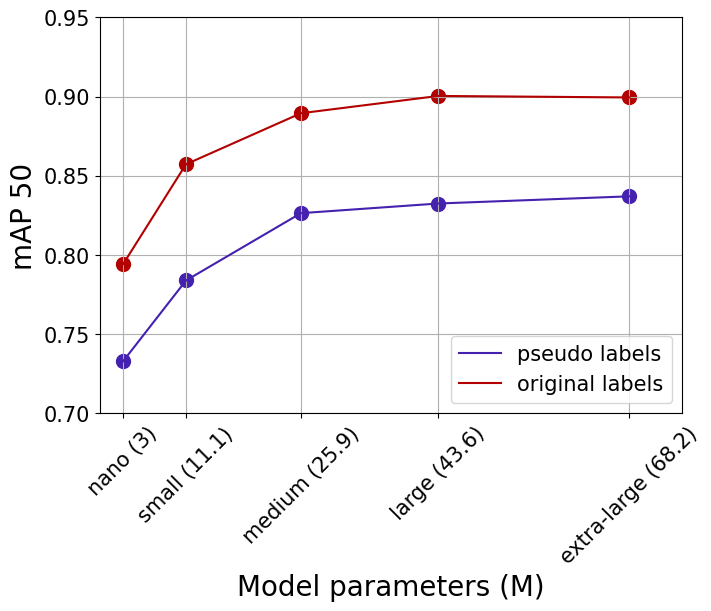

In [13]:
save_dir = 'outputs/all_models'
os.makedirs(save_dir, exist_ok=True)
model_names = ['nano', 'small', 'medium', 'large', 'extra-large']

map5095_GD = [x.map for x in data_test_GD]
map50_GD = [x.map50 for x in data_test_GD]
map5095_orig = [x.map for x in data_test]
map50_orig = [x.map50 for x in data_test]

parametrs = [3, 11.1, 25.9, 43.6, 68.2]
model_names = [f'{x} ({y})' for x, y in list(zip(model_names, parametrs))]


fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7, 6),
                        sharex=True, sharey=True, layout="constrained")
markers = ['o', 'o', 'o', 'o', 'o']

for i in range(len(parametrs)):
    axs.scatter(parametrs[i], map50_GD[i], s=100, marker=markers[i], color="#4421af")
for i in range(len(parametrs)):
    axs.scatter(parametrs[i], map50_orig[i], s=100, marker=markers[i], color="#b30000")



axs.plot(parametrs, map50_GD, color="#4421af", linewidth=1.5, label='pseudo labels')
axs.plot(parametrs, map50_orig, color="#b30000", linewidth=1.5, label='original labels')


axs.set_xlim(0, parametrs[-1]*1.1)
axs.set_ylim(0.7, 0.95)
axs.grid(True)
axs.legend(fontsize=15,loc='lower right')

# Увеличение размера подписей и величин на осях
axs.set_xlabel("Model parameters (M)", fontsize=20)
axs.set_ylabel("mAP 50", fontsize=20)
axs.tick_params(axis='both', which='major', labelsize=15)

# Указание названий каждой модели вместо оси X
plt.xticks(parametrs, model_names, rotation=45, fontsize=15)
fig.savefig(f'{save_dir}/mAP 50 all models')

plt.show()

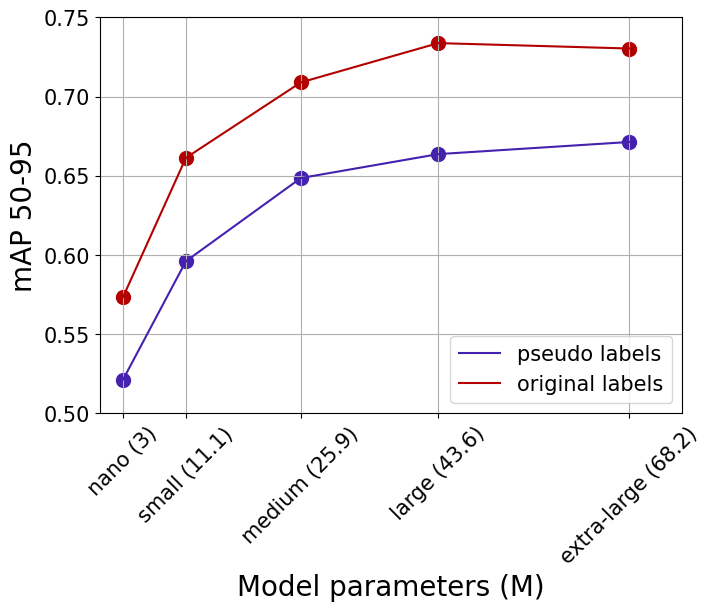

In [11]:
import matplotlib.pyplot as plt

model_names = ['nano', 'small', 'medium', 'large', 'extra-large']

map5095_GD = [x.map for x in data_test_GD]
map50_GD = [x.map50 for x in data_test_GD]
map5095_orig = [x.map for x in data_test]
map50_orig = [x.map50 for x in data_test]


parametrs = [3, 11.1, 25.9, 43.6, 68.2]
model_names = [f'{x} ({y})' for x, y in list(zip(model_names, parametrs))]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7, 6),
                        sharex=True, sharey=True, layout="constrained")
# markers = ['o', 's', '^', 'x', 'D']
markers = ['o', 'o', 'o', 'o', 'o']

for i in range(len(parametrs)):
    axs.scatter(parametrs[i], map5095_GD[i], s=100, marker=markers[i], color="#4421af")
for i in range(len(parametrs)):
    axs.scatter(parametrs[i], map5095_orig[i], s=100, marker=markers[i], color="#b30000")



axs.plot(parametrs, map5095_GD, color="#4421af", linewidth=1.5, label='pseudo labels')
axs.plot(parametrs, map5095_orig, color="#b30000", linewidth=1.5, label='original labels')


axs.set_xlim(0, parametrs[-1]*1.1)
axs.set_ylim(0.5, 0.75)
axs.grid(True)
axs.legend(fontsize=15,loc='lower right')

# Увеличение размера подписей и величин на осях
axs.set_xlabel("Model parameters (M)", fontsize=20)
axs.set_ylabel("mAP 50-95", fontsize=20)
axs.tick_params(axis='both', which='major', labelsize=15)

# Указание названий каждой модели вместо оси X
plt.xticks(parametrs, model_names, rotation=45, fontsize=15)

plt.show()
fig.savefig(f'{save_dir}/mAP 50-95 all models')


In [14]:
def get_single_data(path):
    if path.endswith('.csv'):
        data = prepare_df(path)
    else:
        data = pickle.load(open(path, "rb"))
    return data

def get_mAP_from_pickle(pickle_data, metric_atr):
    metric = getattr(pickle_data, metric_atr)
    return metric

models = ['nano', 'small', 'medium', 'large', 'extra-large']
models_path = ['nano', 'small', 'medium', 'large', 'extra_large']

dataset_names = ['original dataset', 'pseudo labeled dataset']
dataset_paths = ['orig', 'GD_train_val']

metric_names = ['mAP 50', 'mAP 50-95']
metric_atrs = ['map50','map']


columns = [f'{d_name} {map_metric}' for d_name in dataset_names for map_metric in metric_names ]
indexes = [f'{model}' for model in models]

df = pd.DataFrame(
    columns=columns,
    index=indexes
)

for model, model_path in zip(models, models_path):
    for d_path, d_name in zip(dataset_paths, dataset_names):
        for map_name, map_atr in zip(metric_names, metric_atrs):
                
            full_path = f'../runs/all_models/{d_path}/{model_path}/test/results.pickle'

            res = get_mAP_from_pickle(get_single_data(full_path), map_atr)
            df.loc[f'{model}',f'{d_name} {map_name}'] = res

df = df.astype('float32')
df_3 = df.round(3)
df_3.to_csv(f'{save_dir}/data.csv')

In [15]:
df

,original dataset mAP 50,original dataset mAP 50-95,pseudo labeled dataset mAP 50,pseudo labeled dataset mAP 50-95
nano,0.794187,0.573486,0.732893,0.521353
small,0.857256,0.661326,0.783893,0.596083
medium,0.889467,0.708925,0.826392,0.648560
large,0.900382,0.733738,0.832485,0.663657
extra-large,0.899426,0.730320,0.837016,0.671316


## Vehicle

In [13]:
test_path = [
    '../runs/all_models_Vehicle/orig/nano/test/results.pickle',
    '../runs/all_models_Vehicle/orig/small/test/results.pickle',
    '../runs/all_models_Vehicle/orig/medium/test/results.pickle',
    '../runs/all_models_Vehicle/orig/large/test/results.pickle',
    '../runs/all_models_Vehicle/orig/extra_large/test/results.pickle',
    ]


test_path_GD = [
    '../runs/all_models_Vehicle/GD_train_val/nano/test/results.pickle',
    '../runs/all_models_Vehicle/GD_train_val/small/test/results.pickle',
    '../runs/all_models_Vehicle/GD_train_val/medium/test/results.pickle',
    '../runs/all_models_Vehicle/GD_train_val/large/test/results.pickle',
    '../runs/all_models_Vehicle/GD_train_val/extra_large/test/results.pickle',
    ]

model_names = ['nano', 'small', 'medium', 'large', 'extra-large']

def prepare_df(path):
    df = pd.read_csv(path)
    df.columns = [x.split(' ')[-1] for x in df.columns]
    return df

data_test = [pickle.load(open(x, "rb")) for x in test_path]
data_test_GD = [pickle.load(open(x, "rb")) for x in test_path_GD]

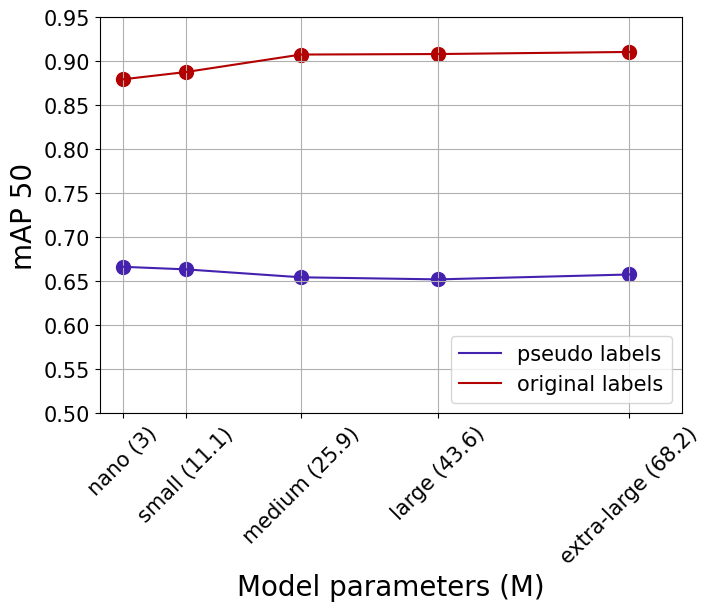

In [15]:
save_dir = 'outputs/Vehicle/all_models'
os.makedirs(save_dir, exist_ok=True)
model_names = ['nano', 'small', 'medium', 'large', 'extra-large']

map5095_GD = [x.map for x in data_test_GD]
map50_GD = [x.map50 for x in data_test_GD]
map5095_orig = [x.map for x in data_test]
map50_orig = [x.map50 for x in data_test]

parametrs = [3, 11.1, 25.9, 43.6, 68.2]
model_names = [f'{x} ({y})' for x, y in list(zip(model_names, parametrs))]


fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7, 6),
                        sharex=True, sharey=True, layout="constrained")
markers = ['o', 'o', 'o', 'o', 'o']

for i in range(len(parametrs)):
    axs.scatter(parametrs[i], map50_GD[i], s=100, marker=markers[i], color="#4421af")
for i in range(len(parametrs)):
    axs.scatter(parametrs[i], map50_orig[i], s=100, marker=markers[i], color="#b30000")



axs.plot(parametrs, map50_GD, color="#4421af", linewidth=1.5, label='pseudo labels')
axs.plot(parametrs, map50_orig, color="#b30000", linewidth=1.5, label='original labels')


axs.set_xlim(0, parametrs[-1]*1.1)
axs.set_ylim(0.5, 0.95)
axs.grid(True)
axs.legend(fontsize=15,loc='lower right')

# Увеличение размера подписей и величин на осях
axs.set_xlabel("Model parameters (M)", fontsize=20)
axs.set_ylabel("mAP 50", fontsize=20)
axs.tick_params(axis='both', which='major', labelsize=15)

# Указание названий каждой модели вместо оси X
plt.xticks(parametrs, model_names, rotation=45, fontsize=15)
fig.savefig(f'{save_dir}/mAP 50 all models')

plt.show()

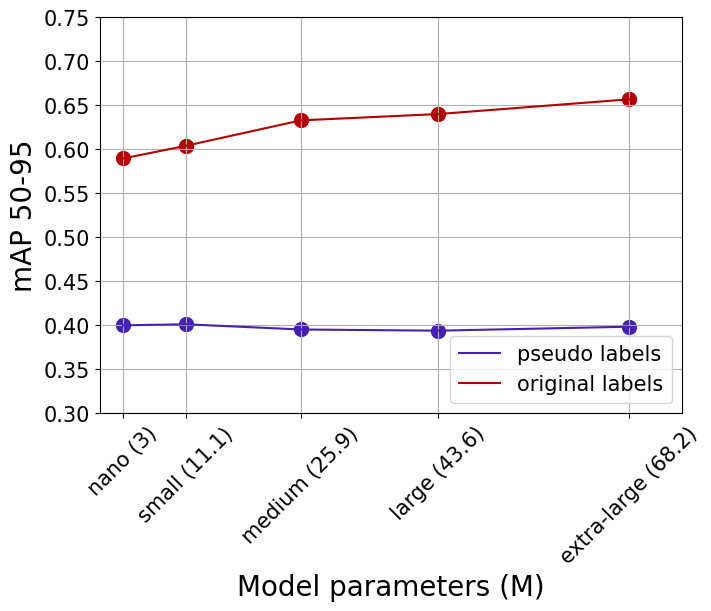

In [18]:
import matplotlib.pyplot as plt

model_names = ['nano', 'small', 'medium', 'large', 'extra-large']

map5095_GD = [x.map for x in data_test_GD]
map50_GD = [x.map50 for x in data_test_GD]
map5095_orig = [x.map for x in data_test]
map50_orig = [x.map50 for x in data_test]


parametrs = [3, 11.1, 25.9, 43.6, 68.2]
model_names = [f'{x} ({y})' for x, y in list(zip(model_names, parametrs))]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7, 6),
                        sharex=True, sharey=True, layout="constrained")
# markers = ['o', 's', '^', 'x', 'D']
markers = ['o', 'o', 'o', 'o', 'o']

for i in range(len(parametrs)):
    axs.scatter(parametrs[i], map5095_GD[i], s=100, marker=markers[i], color="#4421af")
for i in range(len(parametrs)):
    axs.scatter(parametrs[i], map5095_orig[i], s=100, marker=markers[i], color="#b30000")



axs.plot(parametrs, map5095_GD, color="#4421af", linewidth=1.5, label='pseudo labels')
axs.plot(parametrs, map5095_orig, color="#b30000", linewidth=1.5, label='original labels')


axs.set_xlim(0, parametrs[-1]*1.1)
axs.set_ylim(0.3, 0.75)
axs.grid(True)
axs.legend(fontsize=15,loc='lower right')

# Увеличение размера подписей и величин на осях
axs.set_xlabel("Model parameters (M)", fontsize=20)
axs.set_ylabel("mAP 50-95", fontsize=20)
axs.tick_params(axis='both', which='major', labelsize=15)

# Указание названий каждой модели вместо оси X
plt.xticks(parametrs, model_names, rotation=45, fontsize=15)

plt.show()
fig.savefig(f'{save_dir}/mAP 50-95 all models')


In [22]:
def get_single_data(path):
    if path.endswith('.csv'):
        data = prepare_df(path)
    else:
        data = pickle.load(open(path, "rb"))
    return data

def get_mAP_from_pickle(pickle_data, metric_atr):
    metric = getattr(pickle_data, metric_atr)
    return metric

models = ['nano', 'small', 'medium', 'large', 'extra-large']
models_path = ['nano', 'small', 'medium', 'large', 'extra_large']

dataset_names = ['original dataset', 'pseudo labeled dataset']
dataset_paths = ['orig', 'GD_train_val']

metric_names = ['mAP 50', 'mAP 50-95']
metric_atrs = ['map50','map']


columns = [f'{d_name} {map_metric}' for d_name in dataset_names for map_metric in metric_names ]
indexes = [f'{model}' for model in models]

df = pd.DataFrame(
    columns=columns,
    index=indexes
)

for model, model_path in zip(models, models_path):
    for d_path, d_name in zip(dataset_paths, dataset_names):
        for map_name, map_atr in zip(metric_names, metric_atrs):
                
            full_path = f'../runs/all_models_Vehicle/{d_path}/{model_path}/test/results.pickle'

            res = get_mAP_from_pickle(get_single_data(full_path), map_atr)
            df.loc[f'{model}',f'{d_name} {map_name}'] = res

df = df.astype('float32')
df_3 = df.round(3)
df_3.to_csv(f'{save_dir}/data.csv')

In [23]:
df

,original dataset mAP 50,original dataset mAP 50-95,pseudo labeled dataset mAP 50,pseudo labeled dataset mAP 50-95
nano,0.879607,0.589626,0.666554,0.400073
small,0.887866,0.604049,0.663622,0.401235
medium,0.907719,0.632943,0.654627,0.395321
large,0.908297,0.640114,0.652265,0.393973
extra-large,0.910673,0.656863,0.657818,0.398492
